# Monocular depth estimation
## Kiwibot entry project - Sebastián Hernández Reyes

In [1]:
# Imports

import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import onnx
import onnxruntime as rt
import tf2onnx

D:\Documents\Kiwibot\KiwiEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if TF has GPU available
print("Num GPUs Available for TF: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available for TF:  1


In [4]:
# Global Configurations
PROJECT_PATH = 'D:\Documents\Kiwibot\depth-estimation-project'
USEFUL_CAMERAS = [['/video_mapping/left','/video_mapping/left/depth_map'],['/video_mapping/right', '/video_mapping/right/depth_map'], ['/video_mapping/back', '/video_mapping/back/depth_map'],['/camera/color/image_raw', '/camera/color/image_raw/depth_map']]
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMDQ1OWE3Yy0zMzA3LTQzY2ItYmFlOS02YzRjZGY3NGRlZmMifQ=="

## Metrics

For the evaluation of models, the following evaluation metrics were chosen:
* Absolute relative difference (MAE)
* Root Mean Squared Log Error (RMSLE)
* Prediction Time

## Input Data Pipeline

### Examining the data

In [5]:
# Data examination

metadata_path = os.path.join(PROJECT_PATH,'data','metadata.csv')
metadata = pd.read_csv(metadata_path, encoding='utf-8')
metadata.head()

,/video_mapping/left,/video_mapping/right,/camera/color/image_raw,/video_mapping/back,pos_x,pos_y,pos_z,quat_x,quat_y,quat_z,...,timestamp,/video_mapping/back/depth_map,/video_mapping/right/depth_map,/video_mapping/left/depth_map,/camera/color/image_raw/depth_map,lat,lon,roll,pitch,yaw
0,video_mapping_left_image_1642547234833.jpg,video_mapping_right_image_1642547234915.jpg,camera_color_image_raw_image_1642547234869.jpg,video_mapping_back_image_1642547234852.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547234874,video_mapping_back_depth_map_1642547234874.png,video_mapping_right_depth_map_1642547234874.png,video_mapping_left_depth_map_1642547234874.png,camera_color_image_raw_depth_map_1642547234874...,NaN,NaN,NaN,NaN,NaN
1,video_mapping_left_image_1642547235194.jpg,video_mapping_right_image_1642547235169.jpg,camera_color_image_raw_image_1642547235135.jpg,video_mapping_back_image_1642547235234.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547235189,video_mapping_back_depth_map_1642547235189.png,video_mapping_right_depth_map_1642547235189.png,video_mapping_left_depth_map_1642547235189.png,camera_color_image_raw_depth_map_1642547235189...,33.969986,-118.416718,-0.009817,-0.094902,0.769036
2,video_mapping_left_image_1642547235565.jpg,video_mapping_right_image_1642547235538.jpg,camera_color_image_raw_image_1642547235469.jpg,video_mapping_back_image_1642547235473.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547235515,video_mapping_back_depth_map_1642547235515.png,video_mapping_right_depth_map_1642547235515.png,video_mapping_left_depth_map_1642547235515.png,camera_color_image_raw_depth_map_1642547235515...,33.969986,-118.416718,-0.009817,-0.094902,0.769036
3,video_mapping_left_image_1642547236192.jpg,video_mapping_right_image_1642547236156.jpg,camera_color_image_raw_image_1642547236136.jpg,video_mapping_back_image_1642547236227.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547236188,video_mapping_back_depth_map_1642547236188.png,video_mapping_right_depth_map_1642547236188.png,video_mapping_left_depth_map_1642547236188.png,camera_color_image_raw_depth_map_1642547236188...,33.969986,-118.416717,-0.009817,-0.094902,0.769036
4,video_mapping_left_image_1642547236548.jpg,video_mapping_right_image_1642547236535.jpg,camera_color_image_raw_image_1642547236470.jpg,video_mapping_back_image_1642547236453.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547236508,video_mapping_back_depth_map_1642547236508.png,video_mapping_right_depth_map_1642547236508.png,video_mapping_left_depth_map_1642547236508.png,camera_color_image_raw_depth_map_1642547236508...,33.969986,-118.416717,-0.009817,-0.094902,0.769036


In [5]:
images_list = []
depth_masks_list = []

for camera in USEFUL_CAMERAS:
    images_camera = metadata[camera[0]].tolist()
    masks_camera = metadata[camera[1]].tolist()

    images_path = [os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',x) for x in images_camera]
    masks_path = [os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',x) for x in masks_camera]

    images_list = images_list + images_path
    depth_masks_list = depth_masks_list + masks_path

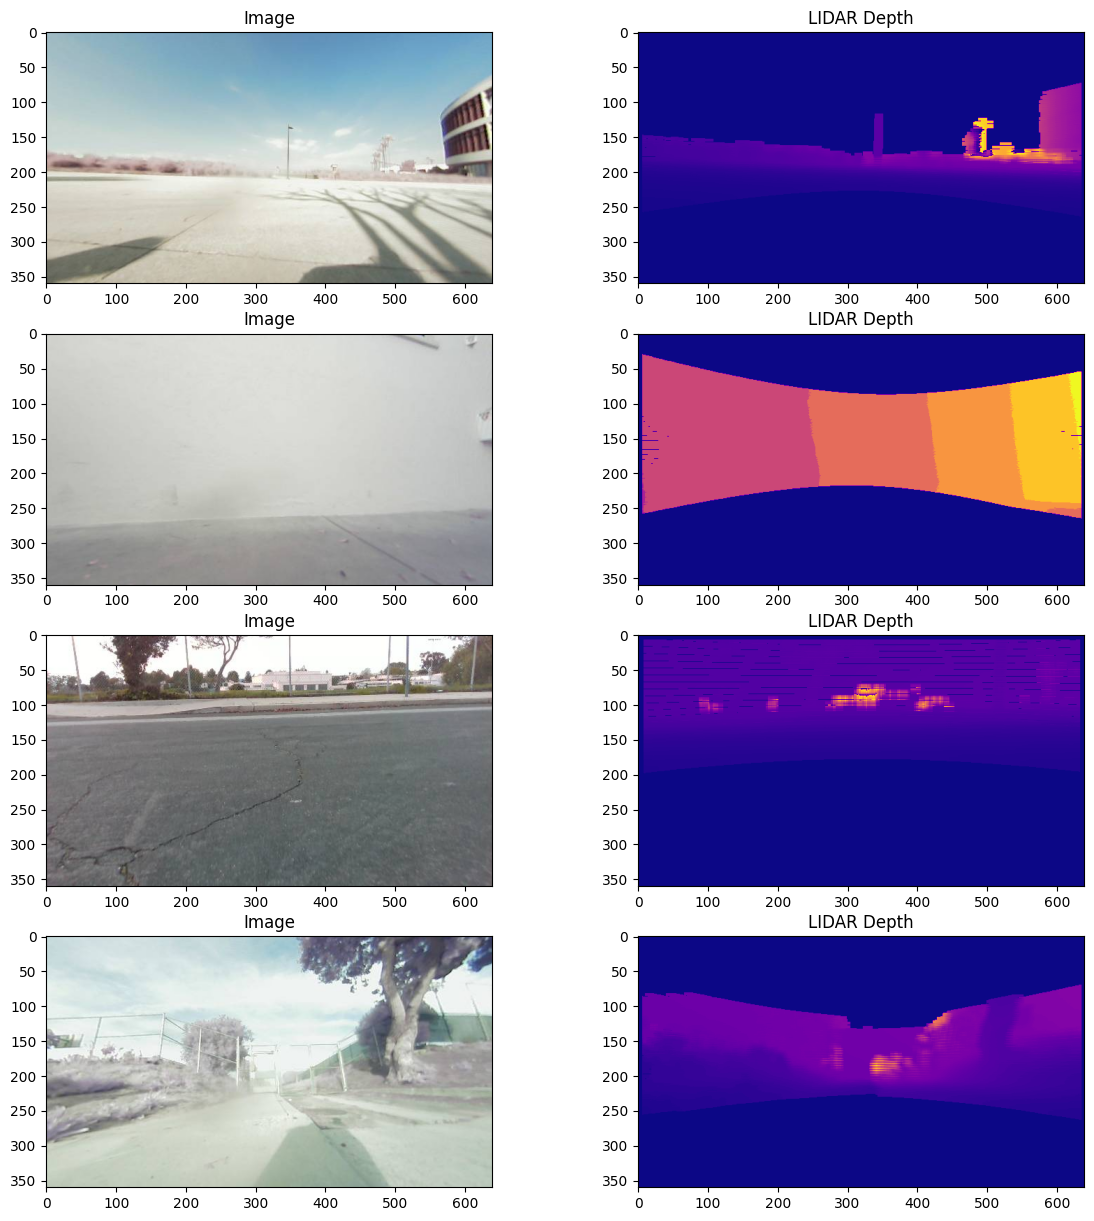

In [6]:
# Check out some images
fig, ax = plt.subplots(4, 2, figsize=(14, 15))

for i in range(4):
    N = random.randint(0, len(images_list))

    img = cv2.imread(images_list[N])[:,:,::-1]
    mask = cv2.imread(depth_masks_list[N],0)

    ax[i,0].imshow(img)
    ax[i,0].set_title('Image')
    ax[i,1].imshow(mask, cmap='plasma')
    ax[i,1].set_title('LIDAR Depth')

plt.show()

### Tensorflow Data Pipeline

In [97]:
# Making the data pipeline for tensorflow
# Some helper functions to transform the list of directions to images

def process_path_tf(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    depth_mask = tf.io.read_file(mask_path)
    depth_mask = tf.image.decode_png(depth_mask, channels=1)

    mask = tf.equal(depth_mask, tf.zeros_like(depth_mask))
    mask = tf.logical_not(mask)

    masked_img = tf.multiply(mask.astype(tf.float32),img)

    final_mask = depth_mask/255

    return masked_img, final_mask

def preprocess_images_tf(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='bilinear')
    input_mask = tf.image.resize(mask, (256, 256), method='bilinear')
    return input_image, input_mask

def augmentation_images_tf(image, mask):
    # First: flip_left_right with 50% prob
    if tf.random.uniform(()) > 0.5:
        flipped_image = tf.image.flip_left_right(image)
        flipped_mask = tf.image.flip_left_right(mask)
    else:
        flipped_image = image
        flipped_mask = mask

    # Second: affine transformation - width and height shift
    h_shift = tf.random.uniform(shape=[], minval=-70, maxval=70, dtype=tf.int64)
    tr_image = tfa.image.translate(flipped_image,[0,h_shift])
    tr_mask = tfa.image.translate(flipped_mask,[0,h_shift])

    return tr_image,tr_mask

In [98]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.9, val_split=0.05, test_split=0.05):
    assert (train_split + test_split + val_split) == 1

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

def prepare_datasets(ds, train_dataset=False):
    image_ds = ds.map(process_path_tf)
    processed_image_ds = image_ds.map(preprocess_images_tf)

    if train_dataset:
        processed_image_ds = processed_image_ds.map(augmentation_images_tf)
    return processed_image_ds

In [99]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(depth_masks_list)

tf_dataset_len = len(image_filenames)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames)).shuffle(tf_dataset_len)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, len(dataset))

r_train_ds = prepare_datasets(train_ds, True)
r_val_ds = prepare_datasets(val_ds)
r_test_ds = prepare_datasets(test_ds)

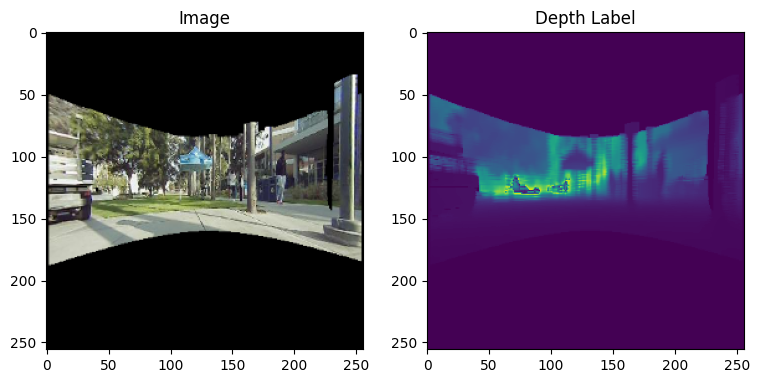

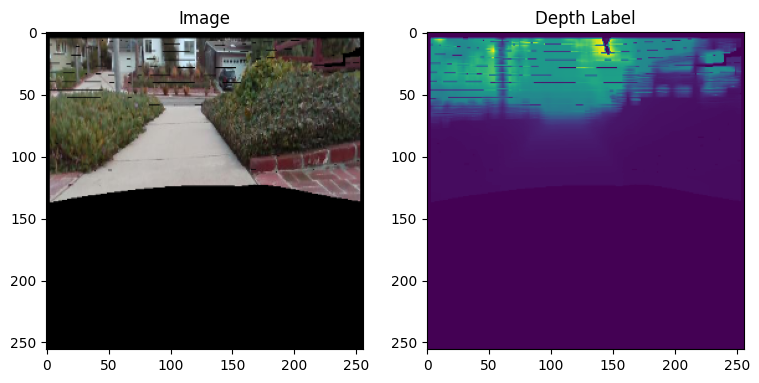

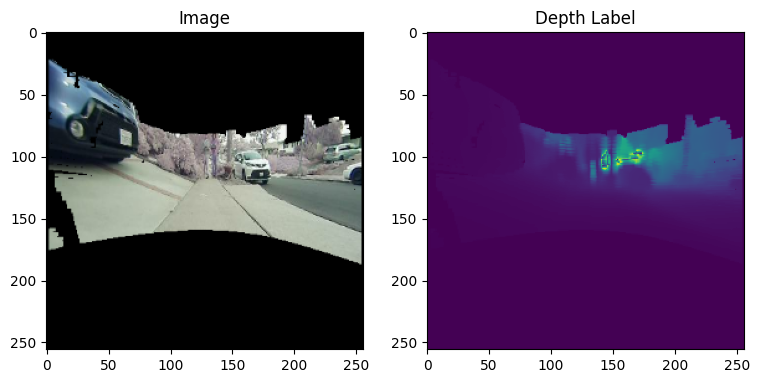

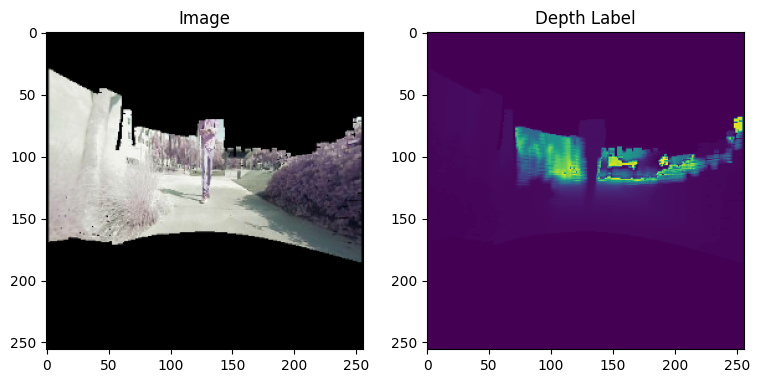

In [100]:
for data in r_val_ds.take(4):
    fig, arr = plt.subplots(1, 2, figsize=(9, 15))
    arr[0].imshow(data[0])
    arr[0].set_title('Image')
    arr[1].imshow(data[1])
    arr[1].set_title('Depth Label')

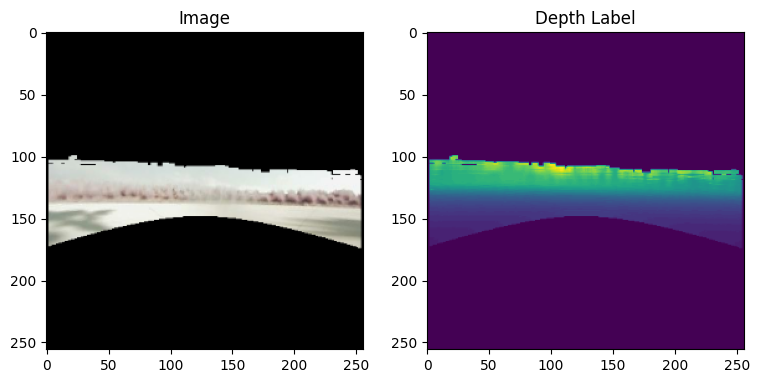

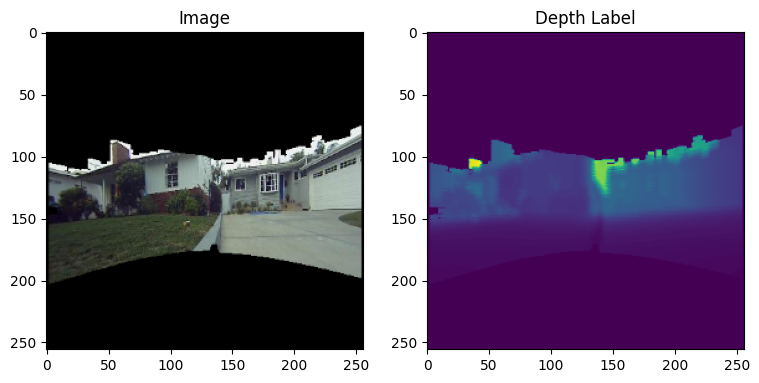

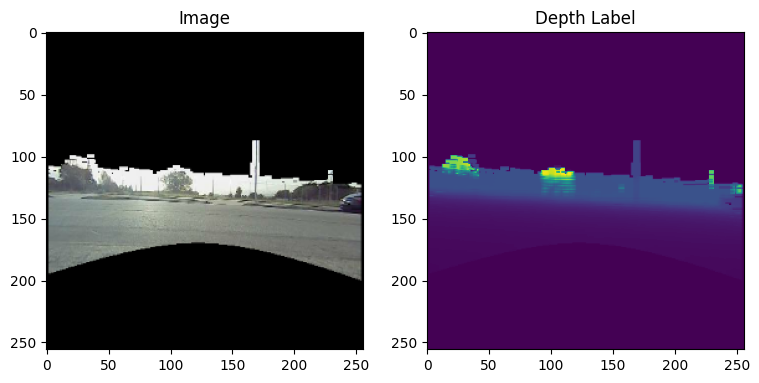

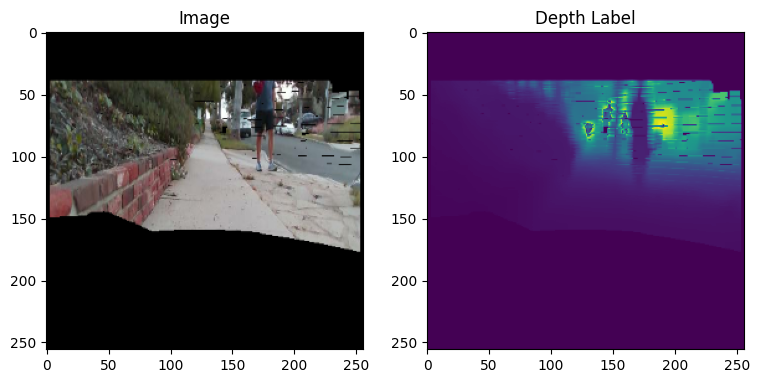

In [101]:
# Inspect Data augmentation
for data in r_train_ds.take(4):
    fig, arr = plt.subplots(1, 2, figsize=(9, 15))
    arr[0].imshow(data[0])
    arr[0].set_title('Image')
    arr[1].imshow(data[1])
    arr[1].set_title('Depth Label')

## Simple U-Net

### Training

In [44]:
class DownscaleBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [85]:
def non_finite_reduce_mean(tensor):
    return tf.reduce_mean(tf.boolean_mask(tensor, tf.math.is_finite(tensor)))

def masked_tensor(tensor,mask):
    return tf.boolean_mask(tensor, tf.math.greater(mask,0))

In [86]:
class RMSLE(tf.keras.metrics.Metric):

    def __init__(self, name='rmsle', **kwargs):
        super(RMSLE, self).__init__(name=name, **kwargs)
        self.rmsle_value = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, target, pred, sample_weight=None):
        pred = tf.convert_to_tensor(pred)
        target = tf.cast(target, pred.dtype)

        first_log = tf.math.log(tf.keras.backend.maximum(pred, tf.keras.backend.epsilon()) + 1.0)
        second_log = tf.math.log(tf.keras.backend.maximum(target, tf.keras.backend.epsilon()) + 1.0)
        mean = non_finite_reduce_mean(
            tf.math.squared_difference(first_log, second_log)
        )
        return self.rmsle_value.assign(tf.sqrt(mean))

    def result(self):
        return self.rmsle_value

    def reset_state(self):
        self.rmsle_value.assign(0)

In [87]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):

        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.rmsle = RMSLE()
        self.mae = tf.keras.metrics.MeanAbsoluteError(name="mae")

        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):

        # Casting
        pred = tf.convert_to_tensor(pred)
        target = tf.cast(target, pred.dtype)
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        abs_dx = tf.abs(dx_true)
        abs_dy = tf.abs(dy_true)
        weights_x = tf.exp(tf.sigmoid(non_finite_reduce_mean(abs_dx)))
        weights_y = tf.exp(tf.sigmoid(non_finite_reduce_mean(abs_dy)))


        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = non_finite_reduce_mean(abs(smoothness_x)) \
                                + non_finite_reduce_mean(abs(smoothness_y))

        # Structural similarity (SSIM) index
        ssim_loss = non_finite_reduce_mean(
            1 - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = non_finite_reduce_mean(tf.abs(target - pred))

        tf.debugging.check_numerics(target, message='The input data has problems')
        tf.debugging.check_numerics(pred, message='The predictions has problems')
        tf.debugging.check_numerics(ssim_loss, message='SSIM Loss has problems')


        loss = (
                (self.ssim_loss_weight * ssim_loss)
                + (self.l1_loss_weight * l1_loss)
                + (self.edge_loss_weight * depth_smoothness_loss)
        )
        return loss

    @property
    def metrics(self):
        return [self.loss_metric, self.mae, self.rmsle]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)

        masked_pred = masked_tensor(pred,target)
        masked_target = masked_tensor(target,target)

        self.mae.update_state(masked_target, masked_pred)
        self.rmsle.update_state(masked_target,masked_pred)

        return {
            "loss": self.loss_metric.result(),
            "mae": self.mae.result(),
            "rmsle": self.rmsle.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        masked_pred = masked_tensor(pred,target)
        masked_target = masked_tensor(target,target)

        self.loss_metric.update_state(loss)
        self.mae.update_state(masked_target, masked_pred)
        self.rmsle.update_state(masked_target, masked_pred)

        return {
            "loss": self.loss_metric.result(),
            "mae": self.mae.result(),
            "rmsle": self.rmsle.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [88]:
# Hyperparameters
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 15
BATCH_SIZE = 64

In [89]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    epsilon=1e-5,
    clipnorm=1.0,
    clipvalue=0.5,
)

# Compile the model
simple_unet = DepthEstimationModel()
simple_unet.compile(optimizer)

In [102]:
batched_train = r_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_val = r_val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_test = r_test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [91]:
# checkpoint

filepath= os.path.join(PROJECT_PATH,'models\custom-formats\weights-improvement-{epoch:02d}.tf')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# NaN Callback
nan_callback = tf.keras.callbacks.TerminateOnNaN()

In [ ]:
simple_unet.load_weights('D:\Documents\Kiwibot\depth-estimation-project\models\custom-formats\simple_unet.tf')

In [108]:
run = neptune.init(
    project="jushernandezre/depth-estimation",
    api_token=NEPTUNE_TOKEN,
)

neptune_cbk = NeptuneCallback(run=run, base_namespace="training", log_model_diagram= False, log_on_batch=True)

https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-42
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
simple_unet_history = simple_unet.fit(
    batched_train,
    epochs=EPOCHS,
    validation_data=batched_val,
    callbacks=[neptune_cbk, nan_callback, checkpoint],
)

In [117]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-42


In [105]:
simple_unet.evaluate(batched_test)

60/60 [==============================] - 21s 340ms/step - loss: 0.0293 - mae: 0.0415 - rmsle: 0.0611


[0.029301710426807404, 0.041527677327394485, 0.06112881377339363]

1/1 [==============================] - 0s 16ms/step


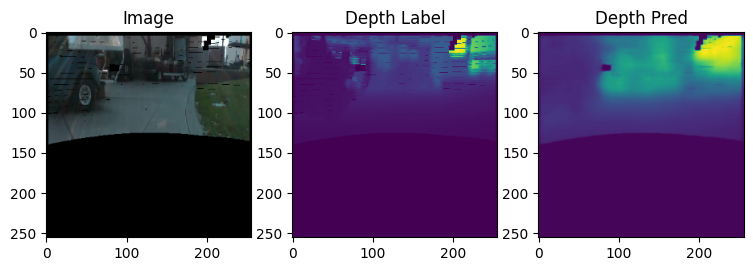

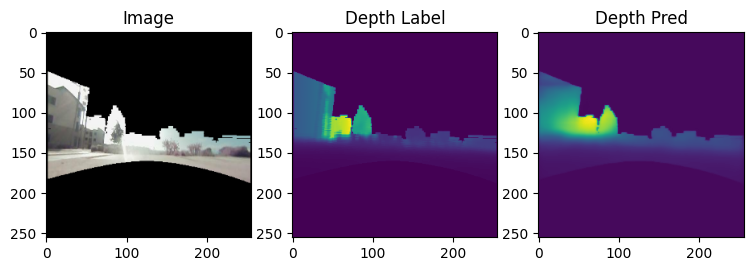

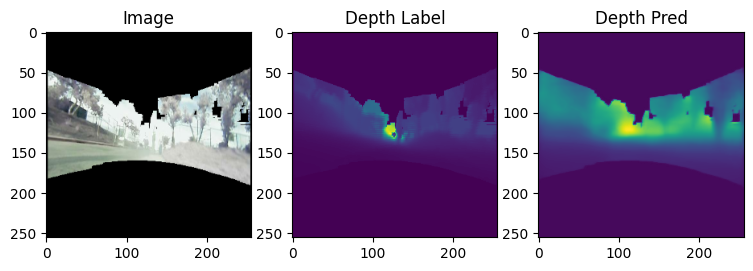

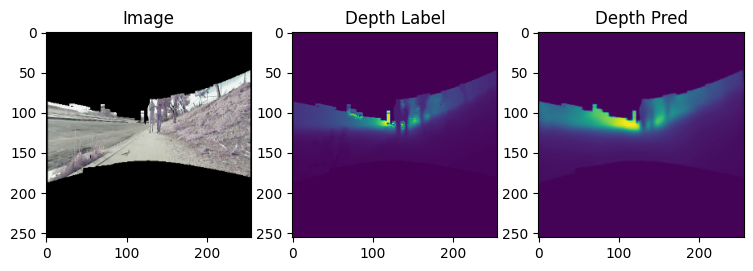

In [116]:
# Inspect Results
for data in r_test_ds.take(4):
    pred_mask = simple_unet.predict(tf.expand_dims(data[0],0))
    pred_mask_np = pred_mask.squeeze()
    fig, arr = plt.subplots(1, 3, figsize=(9, 15))
    arr[0].imshow(data[0])
    arr[0].set_title('Image')
    arr[1].imshow(data[1])
    arr[1].set_title('Depth Label')
    arr[2].imshow(pred_mask_np)
    arr[2].set_title('Depth Pred')

In [107]:
# Saving in ONNX format
spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)
output_path = "D:\\Documents\\Kiwibot\\depth-estimation-project\\models\\ONNX\\simple_unet.onnx"

model_proto, _ = tf2onnx.convert.from_keras(simple_unet, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [119]:
# Saving final in tf format
simple_unet.save('D:\\Documents\\Kiwibot\\depth-estimation-project\\models\\custom-formats\\simple_unet.tf')

INFO:tensorflow:Assets written to: D:\Documents\Kiwibot\depth-estimation-project\models\custom-formats\simple_unet.tf\assets


INFO:tensorflow:Assets written to: D:\Documents\Kiwibot\depth-estimation-project\models\custom-formats\simple_unet.tf\assets


### Prediction

In [28]:
model_file_path = os.path.join(PROJECT_PATH,'models','ONNX','simple_unet.onnx')

In [13]:
input_images_camera = [x[0] for x in USEFUL_CAMERAS]
images_paths = metadata[input_images_camera]

test_images_paths = []
N = random.randint(0,images_paths.shape[0])
for i in range(images_paths.shape[1]):
    test_images_paths.append(os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',images_paths[input_images_camera[i]][N]))

In [49]:
test_images = np.zeros((4,256,256,3),dtype=np.float32)
for i, image_path in enumerate(test_images_paths):
    img = cv2.imread(image_path)[:,:,::-1]
    img_resized = cv2.resize(img,(256,256),cv2.INTER_CUBIC)
    img_norm = img_resized/255
    test_images[i] = img_norm

In [29]:
providers = ['CUDAExecutionProvider']
sess = rt.InferenceSession(model_file_path, providers=providers)

In [52]:
%%time
onnx_pred = sess.run(None, {"input": test_images})

CPU times: total: 31.2 ms
Wall time: 37 ms


In [54]:
onnx_pred_np  = np.array(onnx_pred).squeeze()

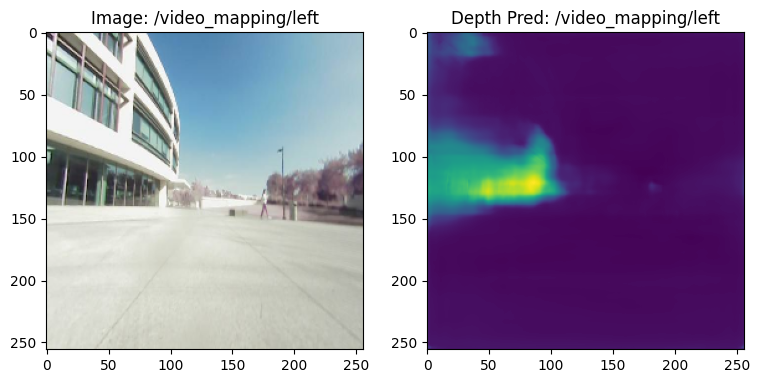

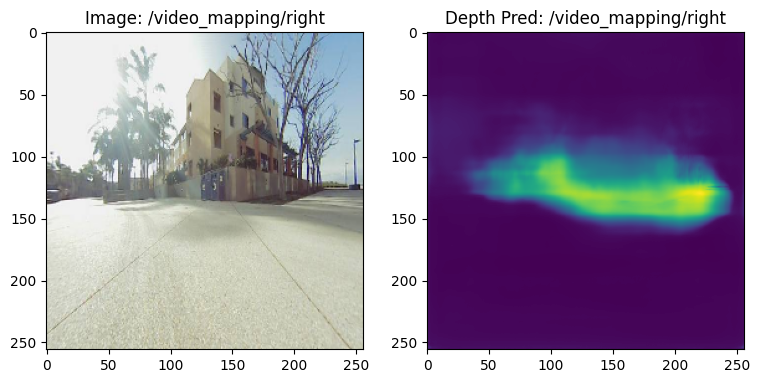

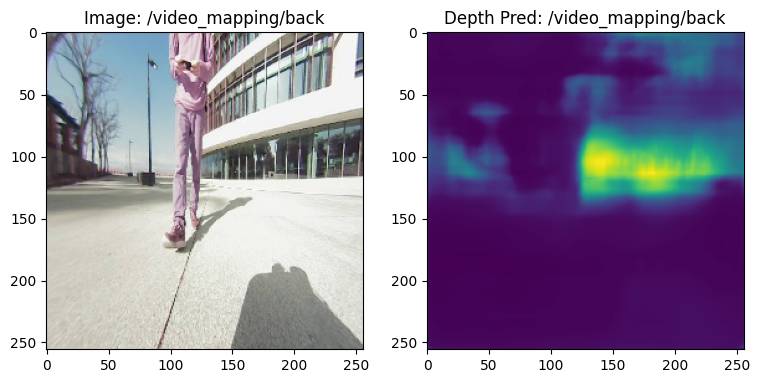

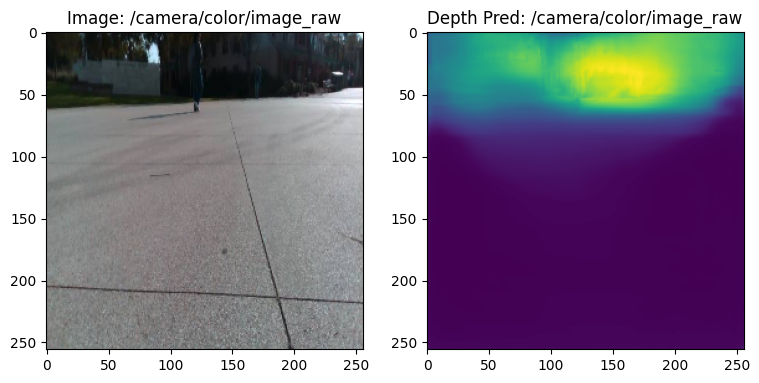

In [64]:
for i,camera in enumerate(input_images_camera):
    fig, arr = plt.subplots(1, 2, figsize=(9, 15))
    arr[0].imshow(test_images[i].astype(float))
    arr[0].set_title(f'Image: {camera}')
    arr[1].imshow(onnx_pred_np[i])
    arr[1].set_title(f'Depth Pred: {camera}')

## References
* [Monocular Depth Estimation Using Deep Learning: A Review](https://www.mdpi.com/1424-8220/22/14/5353/pdf?version=1658138962)
* [Depth Estimation - Papers with code](https://paperswithcode.com/task/depth-estimation)
* [High Quality Monocular Depth Estimation via Transfer Learning](https://arxiv.org/pdf/1812.11941.pdf)
* [Keras tutorial - Depth Estimation](https://keras.io/examples/vision/depth_estimation/)
* [Vision Transformers for Dense Prediction - Code](https://github.com/isl-org/DPT)
* [Vision Transformers for Dense Prediction - Paper](https://arxiv.org/pdf/2103.13413.pdf)
* [DPT Large model in Hugging Face](https://huggingface.co/Intel/dpt-large)